In [ ]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset
import numpy as np
import scipy.io.wavfile

print(torch.__version__)
print(torchaudio.__version__)

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


1.12.0+cu113
0.12.0+cu113


In [ ]:
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)

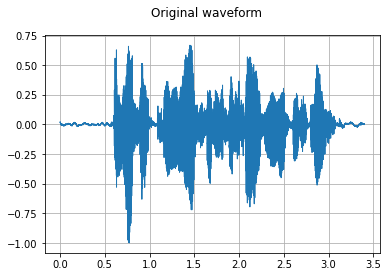

In [ ]:
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
signal, sample_rate = torchaudio.load(SAMPLE_SPEECH)

plot_waveform(signal, sample_rate, title="Original waveform")
Audio(signal.numpy(), rate=sample_rate)

In [ ]:
display(sample_rate)  #1초에 몇번 sampling 했나
display(signal)
display(signal.size(1))
display(signal.size(1)/sample_rate)  #음성이 몇초짜리인지 

16000

tensor([[0.0183, 0.0180, 0.0180,  ..., 0.0018, 0.0019, 0.0032]])

54400

3.4

In [ ]:
#spectrogram
n_fft = 1024
win_length = None
hop_length = 512

spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

<Figure size 1152x432 with 0 Axes>

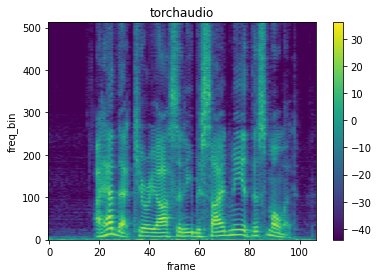

In [ ]:
#transform
spec = spectrogram(signal)
plt.figure(figsize=(16,6))
plot_spectrogram(spec[0], title="torchaudio")

-----


# 오디오 피쳐를 뽑는 방법 2가지
### 1. MFCC로 feature 추출
### 2. Mel spectrogram으로 feature 추출
 

**MFCC VS Mel-Spectrogram**
- MFCC : 연산량이 적고, 일반적인 학습 데이터(도메인에 한정되지 않은) 에 적합함

- Mel-Spectrogram : 연산량이 많지만(CNN으로 써야하는) 특정 도메인의 학습 데이터에 적합함

.  
. 

▶ 음성 데이터에서 feature를 어떤 방법/파라미터를 사용하여 뽑느냐에 따라 모델 성능이 좌우될 수 있기 때문에 피처 뽑는 방법은 중요함 !

▶ librosa 라이브러리 or torchaudio를 통해서 feature를 뽑을 수 있음

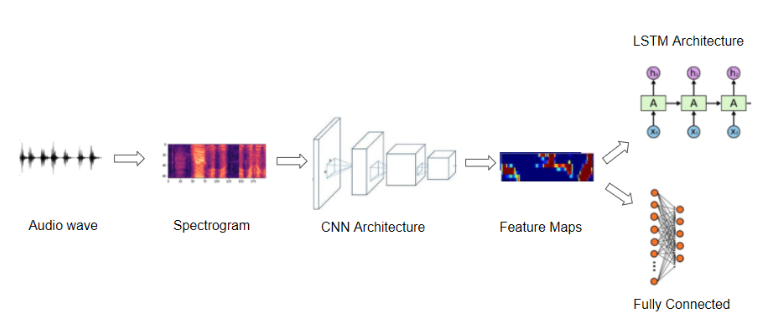

----

# MFCCs(Mel-Frequency Cepstral Coefficients)
- MFCCs란, 음성 데이터(오디오신호)에서 추출할 수 있는 feature로, 소리의 고유한 특징을 나타내는 수치
- 즉, 음성 데이터를 벡터화 시키는것 

- x: 소리가 떨리는 세기(진폭)를 시간 순서대로 나열한 것
- sampling rate(sr): 1초당 샘플의 개수

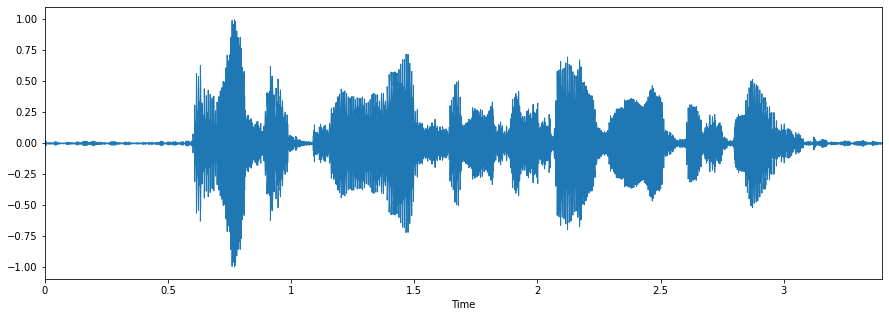

In [ ]:
import librosa.display
#오디오 파일을 불러옴
# sampling rate를 지정하지 않고 불러오면, default = 22050kHz
x, sr = librosa.load(download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"))

#signal plot
plt.figure(figsize=(15,5))
librosa.display.waveplot(x, sr=sr)
Audio(x, rate=sr)

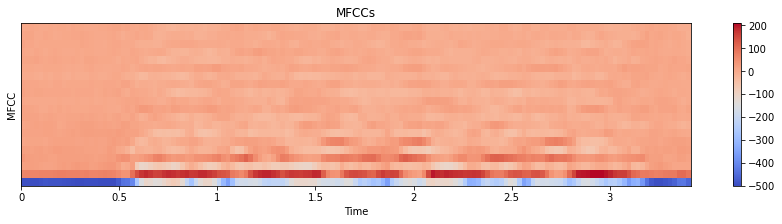

mfccs shape : (20, 147) 

mfccs:
 [[-493.02045   -493.1209    -495.91415   ... -433.67474   -428.36212
  -458.5369   ]
 [  64.68731     68.110535    69.224304  ...  102.88878    107.77565
    89.49183  ]
 [  21.9445      22.513662    24.090649  ...   10.3635845    9.466819
     8.919676 ]
 ...
 [  13.8904915   10.705364     9.239777  ...    6.082549     2.4985294
    -2.3834548]
 [  10.923679    11.891385    13.255766  ...    7.1606236    2.016142
    -6.979039 ]
 [   5.2769523    7.1647463   10.028931  ...   -3.7282085   -4.454853
    -4.5560093]]


In [ ]:
mfccs = librosa.feature.mfcc(x, sr=sr) 
#이 외에 다른 옵션들이 많음 ! 뒤에서 다시 설명

# Displaying  the MFCCs:
fig,ax = plt.subplots(figsize=(15, 3))
img = librosa.display.specshow(mfccs, sr=sr, x_axis='time')
fig.colorbar(img, ax=ax)
ax.set(title='MFCCs')
plt.ylabel('MFCC')
plt.show()
print(f'mfccs shape : {mfccs.shape} \n')
print(f'mfccs:\n {mfccs}')

mfccs shape : (MFCC coef, time frames(시간축 방향 성분수))

----
- MFCCs 를 만드는 전체 과정 그림

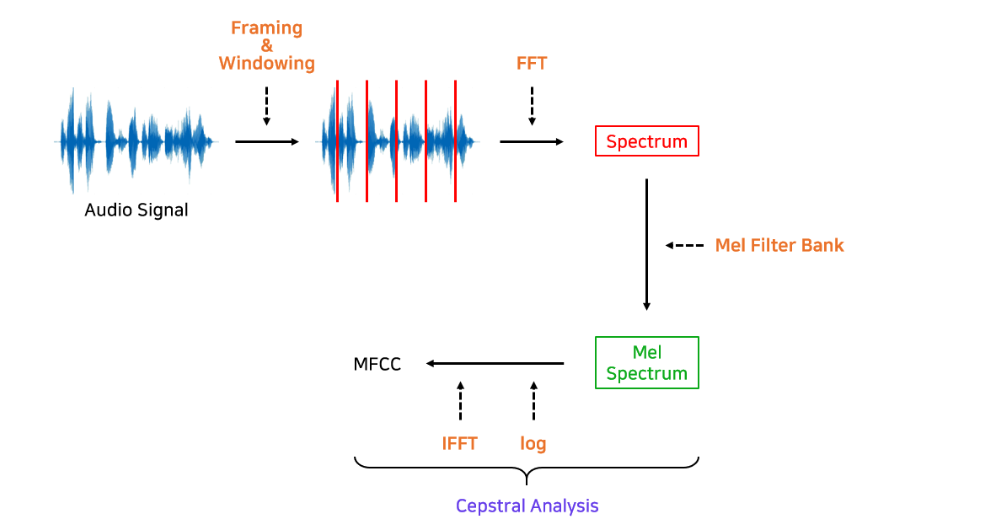

# 용어 정리 및 추출하는 과정
#### 1. MFCC는 입력 음성을 짧은 구간(대개 25ms 내외)으로 나누는데, 전체 오디오 신호를 일정한 간격으로 잘게 쪼개진 음성을 **프레임(frame)**이라고 한다.
#### 2. 프레임 각각에 푸리에 변환(Fourier Transform)을 실시한 결과를 **스펙트럼(spectrum)**이라고 한다.
- 오디오 신호는 시간에 따른 음압 즉, 시간영역(time domain)의 표현인데, 푸리에 변환은 주파수 영역(frequency domain)으로 바꿔줌  
- 주파수 영역으로 바꾸게 되면, 음성 신호에 저음이 얼마나 있고 고음이 얼마나 있는지를 정량적으로 구할 수 있음
- 이렇게 주파수에 대한 정보를 가진 spectrum에서 소리의 고유한 특징을 추출할 수 있게 됨.

#### 3. 스펙트럼에 사람의 말소리 인식에 민감한 주파수 영역대는 세밀하게 보고 나머지 영역대는 상대적으로 덜 촘촘히 분석하는 필터(Mel Filter Bank)를 적용한 것을 **멜 스펙트럼(Mel Spectrum)**이라고 한다.

- mel이란? 달팽이관을 모티브로 따온 값  (mel-scale: 달팽이관 특성 고려한 값)
- 각 스펙트럼의 제곱인 파워 스펙트로그램에 mel-scale에 기반한 Mel scale filter bank를 사용해 차원 수를 줄입니다. 


#### 4.  cepstral 분석을 적용해 MFCC를 구합니다. 
- cepstral 분석은 푸리에 변환을 거쳤을 때 시간 축에서 천천히 변하는 정보가 낮은 주파수 성분에 위치하고, 빨리 변하는 정보가 높은 주파수 성분에 위치한다는 점에 착안한 방법


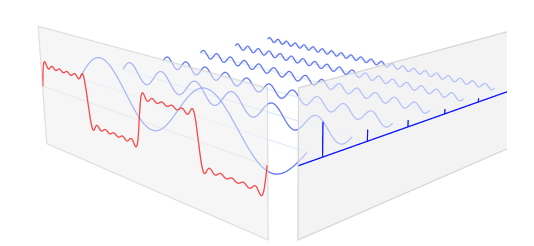

*(참고) 왜 음성을 짧게 쪼개는가?(framing)   
MFCC를 만들 때 푸리에 변환을 실시하는데, 그러면 마치 스냅샷을 찍는 것처럼 해당 음성의 주파수별 정보를 확인할 수 있음.  
하지만!! 음성 신호는 아주 빠르게 변화(non-stationary)하기 때문에 음성신호가 길다면 빠르게 변화하는 신호의 주파수 정보를 정확히 캐치하기 어려울 뿐더러 주파수 정보가 전체 시간 구간에 걸쳐 뭉뚱 그려져 음성 인식 모델의 피처로서 제대로 작동하기 어려울 것임.  
그래서 음성 신호가 stationary하다고 가정해도 좋을 만큼 음성신호를 짧은 구간으로 쪼갠다*

-------

(1025, 147)


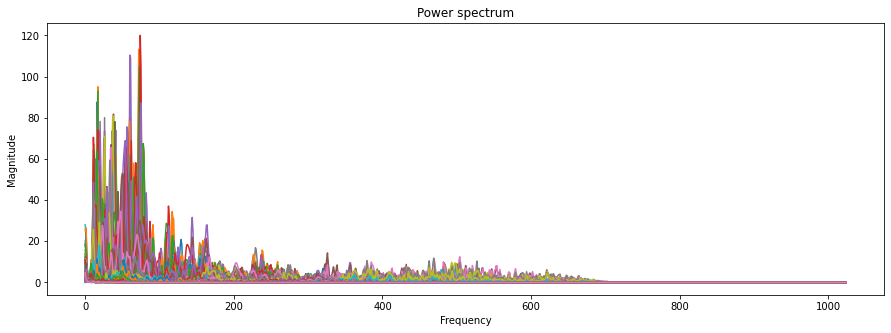

In [ ]:
#푸리에 변환 : time domain -> frequency domain으로 바꿔줌
#stft() : 음성을 잘게 잘라서 각 작은 조각에 푸리에 변환을 적용한 것

y, sr = librosa.load(download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"))

D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
print(D.shape)
plt.figure(figsize=(15,5))
plt.plot(D)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")
plt.show()

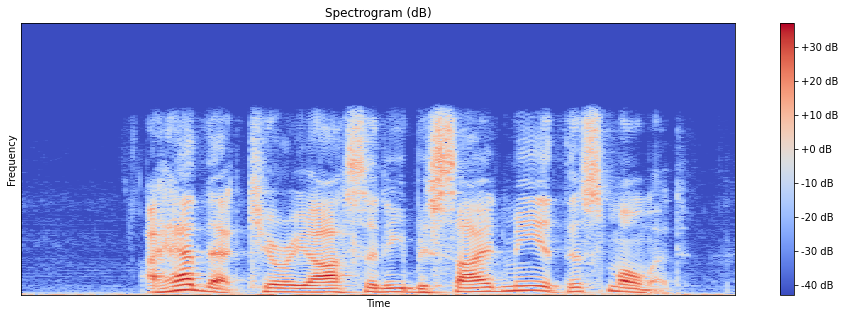

In [ ]:
# STFT -> spectrogram

hop_length = 256
n_fft = 1024

hop_length_duration = float(hop_length) / sr
n_fft_duration = float(n_fft) / sr

stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)

magnitude = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(magnitude)
plt.figure(figsize=(16,5))
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")
plt.show()

---

In [ ]:
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
import librosa.display

SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
x, sr = librosa.load(SAMPLE_SPEECH)
signal, sample_rate = torchaudio.load(SAMPLE_SPEECH)

print(f'librosa로 불러온 signal: \n{type(x)} \n{x}')
print(f'\ntorchaudio로 불러온 signal: \n{type(signal)} \n{signal}')

librosa로 불러온 signal: 
<class 'numpy.ndarray'> 
[0.01751204 0.02015344 0.01686731 ... 0.0017543  0.00305664 0.00245359]

torchaudio로 불러온 signal: 
<class 'torch.Tensor'> 
tensor([[0.0183, 0.0180, 0.0180,  ..., 0.0018, 0.0019, 0.0032]])


---
## 오디오 피쳐 뽑는 방법 2번째
### log-mel spectrogram


- Spectrogram : 시간에 따른 신호 주파수의 스펙트럼 그래프
- Mel-spectrogram: spectrogram에 mel-filter라는 필터를 적용해서 얻어짐  
  - frequency domain 대신, 사람의 청각 민감도를 고려한 **mel-scale**를 사용하여 변환시켜줌
  - 진폭(Amplitude) 대신에 **데시벨 scale**를 사용하게 됨


-> 마지막에 멜 스펙토그램에 log를 취해서 추출하거나
`데시벨(dB) = 10*log(magnitude^2)` 를 사용하여 추출



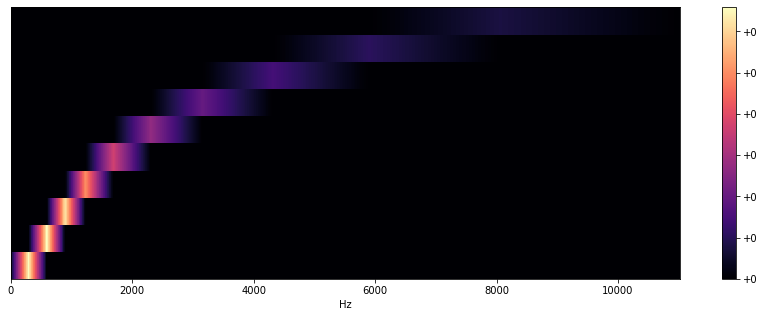

In [ ]:
filter_banks = librosa.filters.mel(n_fft=2048, sr=22050, n_mels=10)
plt.figure(figsize=(15, 5))
librosa.display.specshow(filter_banks, 
                         sr=sr, 
                         x_axis="linear")
plt.colorbar(format="%+2.f")
plt.show()

In [ ]:
mel_spectrogram = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=64)
mel_spectrogram.shape

(64, 147)

In [ ]:
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
log_mel_spectrogram.shape #[Mel, Time]

(64, 147)

shape(64,147) : (주파수 방향 성분 수(n_mels), 시간축 방향 성분수)

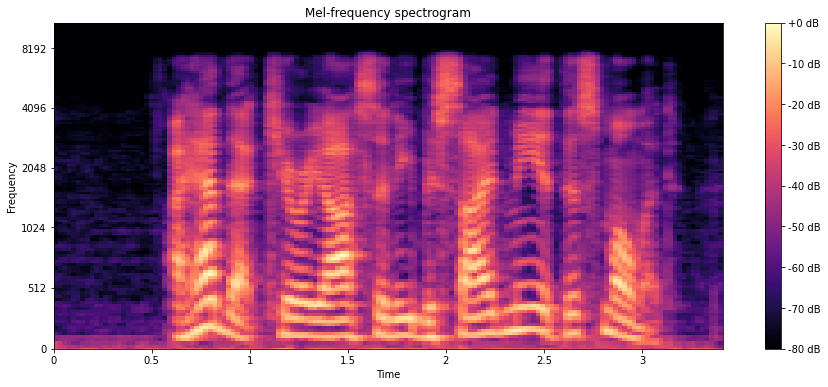

In [ ]:
#librosa.feature.melspectrogram()로 구한 것
y, sr = librosa.load(download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"))
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max) # magnitude를 dB로 바꾸어 크기 바꿔주는건데(log 취했을 때 log(0)이 되면 안되므로), log_offset 옵션 주면 굳이 이렇게 안해도 됨
fig, ax = plt.subplots(figsize=(15, 6))
img = librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis = 'mel')
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

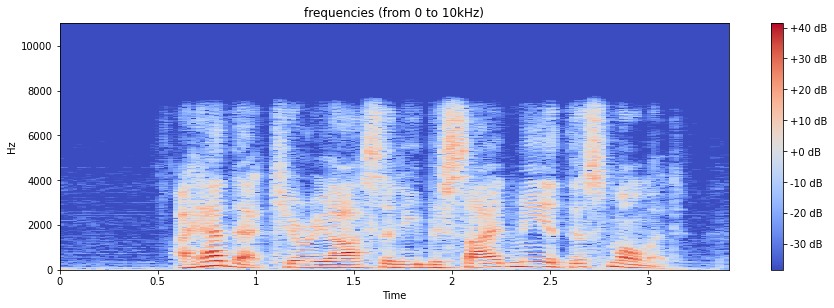

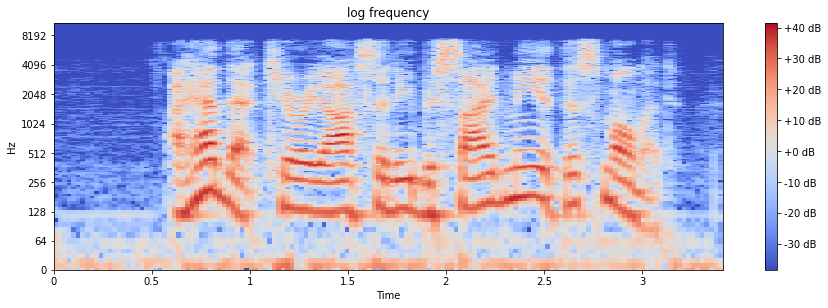

In [ ]:
#librosa.display.specshow() 로 구한 것
x, sr = librosa.load(download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"))
X = librosa.stft(x) #푸리에 변환
Xdb = librosa.amplitude_to_db(abs(X)) 
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.title("frequencies (from 0 to 10kHz)")
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.show()

plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
plt.title("log frequency")
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [ ]:
def log_mel_spectrogram(y,
                        sample_rate=44100,
                        window_length_secs=0.025,
                        hop_length_secs=0.010,
                        num_mels=64, #128
                        log_offset=0.0):
    """Convert waveform to a log magnitude mel-frequency spectrogram.
    """
    window_length = int(round(sample_rate * window_length_secs))
    hop_length = int(round(sample_rate * hop_length_secs))
    fft_length = 2 ** int(np.ceil(np.log(window_length) / np.log(2.0)))

    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sample_rate, n_fft=fft_length, hop_length=hop_length,
                                                     win_length=window_length, n_mels=num_mels)

    return np.log(mel_spectrogram + log_offset)


### librosa.feature.melspectrogram(**parameter)
1. n_fft : 음성의 길이를 얼마만큼 자를것인가(window size)

2. win_length : 음성을 작은 조각으로 자를 때 작은 조각의 크기를 의미
.  
- 자연어 처리 분야에서는 25m(0.025)의 크기를 기본으로 하고 있으며 16000Hz인 음성에서는 400에 해당하는 값.

3. hop_length : 음성을 잘게 자를 때 자르는 간격을 의미. 
- 즉, 이 길이만큼 옆으로 밀면서 작은 조각을 얻습니다. 일반적으로 10ms(0.001)의 크기를 기본으로 하고 있으며 16000Hz인 음성에서는 160에 해당하는 값.
4. n_mels : 적용할 mel filter의 개수를 의미함.

---